In [1]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh

main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_Periodic.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_pkb1_optimize (generic function with 3 methods)

In [2]:
material = "Ag"
n_λ, k_λ = RefractiveIndex(material,main_path,true)
# 400, 365, 325, 1600 cm^-1
λ1 = 532
λ2 = 549
# λ1 = 400
# λ2 = 427
nf = sqrt(1.77)
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
μ = 1
R = 1e-10
g_flat_surface = 147# 125# 147 #25.25
nm1,nm2

(0.054007220216606505 + 3.42898916967509im, 0.05988059701492538 + 3.5892477611940294im)

In [3]:
hr = (λ1+λ2)/nf/4          # Height of Raman molecule
# Geometry parameters of the mesh
L = 400           # Length of the normal region
hair = 500 + hr       # Height of the air region
hs = 300 + hr         # Height of the source location in air
ht = 200 + hr         # Height of the target location in air
hd = 200          # Height of design domain
hsub = 100        # Height of substrate domain below design domain
dpml = 300        # Thickness of the PML
hrd = (hd, hr)
# Characteristic length (controls the resolution, smaller the finer)
# resol = 30        # Number of points per wavelength
l1 = 20      # Air
l2 = 1       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
MeshGenerator(geo_param, meshfile)

LHp=(Inf, hair + hd)  # Start of PML for x,y > 0
LHn=(Inf, hsub)       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)
# run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`)

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 18 (Line)
Info    : Meshing curve 19 (L

PhysicalParameters(0.011444781980290685, 1.3304134695650072, 0.05988059701492538 + 3.5892477611940294im, 0.05988059701492538 + 3.5892477611940294im, 1.0, 1.0e-10, 300.0, (Inf, 903.1323390677645), (Inf, 100.0), 200.0)

In [4]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = (2, 2)  # Filter radius
β = 32.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 1.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1e-4

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = true          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = (r[1])^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)


Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 106496 nodes
Info    : 213188 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 184980, BodyFittedTriangulation(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 7)

(g0_p(p_init; kb1, kb2, phys1, phys2, control, gridap) / L) / g_flat_surface = 49.22784513282283


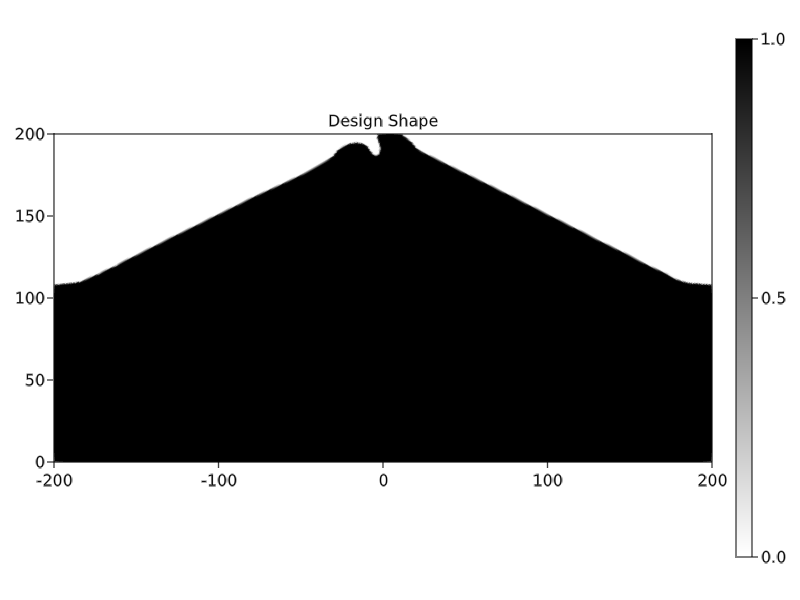

In [6]:
using FileIO
import Images: Gray
# specify the path to your local image file
img_path = "Initial/L400e.png"
img = load(img_path)
data = 1.0 .-Float64.(Gray.(img))
function image_to_function(x, data, Lx, Ly)
    Nx, Ny = size(data)
    if x[2] < 5
        return 1.0
    end
    xi = Nx - Int(round(((x[2]-100)/Lx + 0.5) * Nx))
    yi = Int(round((((x[1]+Ly/2) % Ly)/Ly) * Ny))
    if xi > 0 && xi <= Nx && yi > 0 && yi <= Ny
        return data[xi,yi]
    else
        return 0.0
    end
end

# binit(v) = ∫(v * x->image_to_function(x, data, 200, 150))gridap.dΩ
binit(v) = ∫(v * x->image_to_function(x, data, hd, L))gridap.dΩ
pc_vec = assemble_vector(binit, gridap.FE_P)
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.1] .= 0
p_init[p_init .> 0.1] .= 1

#p_init = ones(gridap.np)
pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh

kb1 = VectorValue(sin(-9/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(7/180*π) * ω2 * nf, 0)
@show g0_p(p_init; kb1, kb2, phys1, phys2, control, gridap)/L/g_flat_surface
fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
# save("Results/shape.png", fig)
fig

In [5]:
function p_bowtie(x, d, h, L, hd)
    dx = abs(x[1]) - d / 2 
    dy = abs(x[2] - hd / 2)
    bowtie = 0
    if dx >= 0 && dy <= h / (L - d) * dx
        bowtie = 1
    end
    return bowtie
end

function p_triangle(x, h, L)
    dx = abs(x[1])
    dy = x[2]
    if dy <= (1-2*dx/L)*h
        return 1
    else
        return 0
    end
end

function p_circle(x, radius)
    if x[2]<=5 || (x[1]^2+(x[2]-radius-5)^2)<=radius^2
        return 1
    else
        return 0
    end
end

p_circle (generic function with 1 method)

(g0_p(p_init; kb1 = 0, kb2 = 0, phys1, phys2, control, gridap) / L) / g_flat_surface = 1.9377098088012759


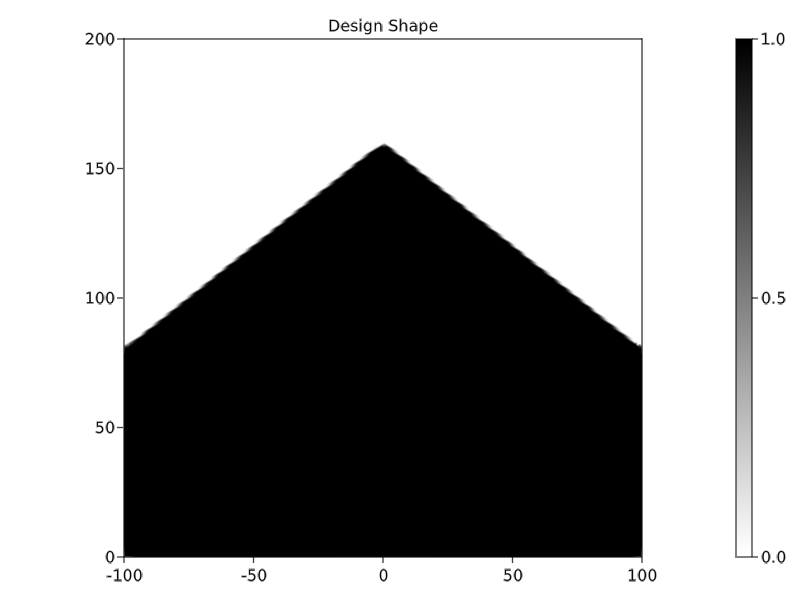

In [6]:


kb = 0
p_trunc(x, ratio) = x[2] < (ratio * hd) ? 1 : 0
# binitialfunc(v) = ∫(v * x->p_trunc(x, 0.5))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_bowtie(x, -11, 95, L, hd))gridap.dΩ
binitialfunc(v) = ∫(v * x->p_triangle(x, 0.8*hd, 2*L))gridap.dΩ
# binitialfunc(v) = ∫(v * x->p_circle(x, 80))gridap.dΩ
pc_vec = assemble_vector(binitialfunc, gridap.FE_P)
#A_base = assemble_matrix((u,v)->(∫(u*v)gridap.dΩ), gridap.FE_P, gridap.FE_Q)
#pc_vec = A_base\pc_vec
p_init = p_extract(pc_vec; gridap)
p_init[p_init .< 0.1] .= 0
p_init[p_init .> 0.1] .= 1.0


pf_vec = pf_p0(p_init; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
@show g0_p(p_init; kb1=0,kb2=0, phys1, phys2, control, gridap)/L/g_flat_surface
fig

In [ ]:
# p_init = ones(gridap.np) * 0.5 #+ rand(gridap.np) * 1e-2
β_list = [8.0, 8.0, 16.0, 16.0, 32.0, 32.0, 32.0]
Q_list = [10.0, 50.0, 100.0, 500.0, 1000.0, 1000.0, 1000.0]
d_list = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-2, 1e-2]*1e2

g_opt = 0
usat = Inf#(10)^2/4
kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(0/180*π) * ω2 * nf, 0)
p_init = p0
#damp = 1

np_init = zeros(gridap.np+2)
np_init[1:end-2] = p0#p_init
np_init[end-1] = kb1[1]
np_init[end] = kb2[1]

for bi = 1 : 6
    β = β_list[bi]
    α = 1/(2*Q_list[bi])
    damp = d_list[bi] * 4
    if bi < 9
        c = 0
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)
    else
        c = (r[1])^4
        control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)
    end

    if bi == 1
        g_opt, p_opt = g0_p_optimize(p_init, 1e-8, 70, kb1, kb2; phys1, phys2, control, gridap, usat, damp)
    
    else
        g_opt, p_opt = g0_p_optimize([], 1e-8, 70, kb1, kb2; phys1, phys2, control, gridap, usat, damp)
    end
#     if bi == 1
#         g_opt, p_opt = g0_pkb_optimize(np_init, 1e-12, 70; phys1, phys2, control, gridap, usat, damp)
    
#     else
#         g_opt, p_opt = g0_pkb_optimize([], 1e-12, 70; phys1, phys2, control, gridap, usat, damp)
#     end
    if isfile("p_opt.value.txt")
        run(`rm p_opt_value.txt`)
    end
    open("p_opt_value.txt", "w") do iop
        for i = 1 : length(p_opt)
            p_temp = p_opt[i]
            write(iop, "$p_temp \n")
        end
    end
    open("g_opt_value.txt", "a") do io
        write(io, "$g_opt \n")
    end
end
@show g_opt

numevals = opt.numevals = 70
numevals = opt.numevals = 70
numevals = opt.numevals = 70
numevals = opt.numevals = 70


In [111]:
kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(-0/180*π) * ω2 * nf, 0)
g0_p(p0; kb1, kb2, phys1, phys2, control, gridap, usat, damp)/L/g_flat_surface

4.574547547298323

((θ1 / π) * 180, (θ2 / π) * 180) = (30.0, 0.0)
(g0_p(p0; kb1, kb2, phys1, phys2, control, gridap, usat, damp) / L) / g_flat_surface = 216.3004771064881


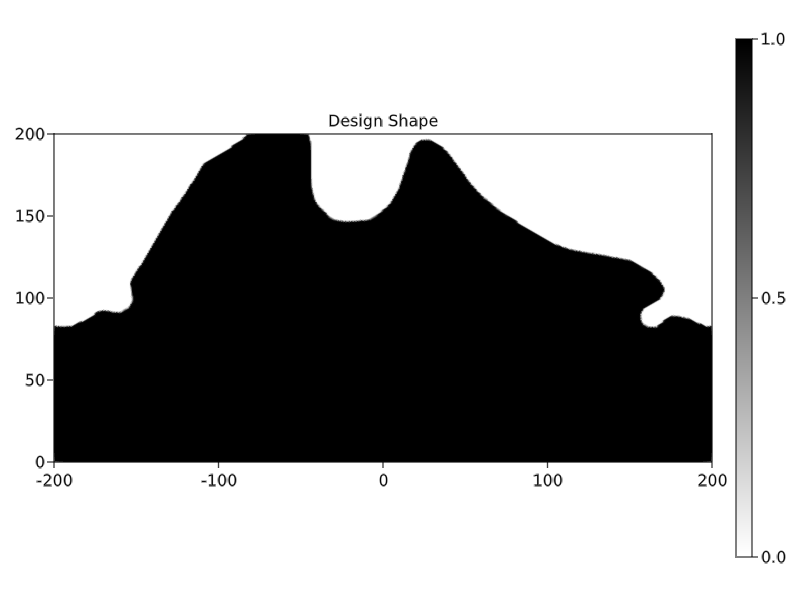

In [5]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(-0/180*π) * ω2 * nf, 0)

if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[1:gridap.np]
    if length(p_max)==(gridap.np+2)
        kb1 = VectorValue(p_max[end-1],0)
        kb2 = VectorValue(p_max[end],0)
    elseif length(p_max)==(gridap.np+1)
        kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
        kb2 = VectorValue(p_max[end],0)
    end
#     p_cutoff = 0.5
#     p0[p0.<p_cutoff] .= 0.0
#     p0[p0.>p_cutoff] .= 1.0
else
    p0 = zeros(gridap.np)
end

θ1 = asin(kb1[1]/phys1.nf/phys1.ω)
θ2 = asin(kb2[1]/phys2.nf/phys2.ω)
@show θ1/π*180, θ2/π*180
usat = Inf#(10)^2/4
damp = 4

pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb1; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v*sqrt(cos(θ1)))gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb2; phys=phys2, control, gridap)
o_vec = assemble_vector(v->(∫(v*sqrt(cos(θ2)))gridap.dΓ_t), gridap.FE_V)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

@show g0_p(p0; kb1, kb2, phys1, phys2, control, gridap, usat, damp)/L/g_flat_surface

fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
save("Results/shape.png", fig)
fig

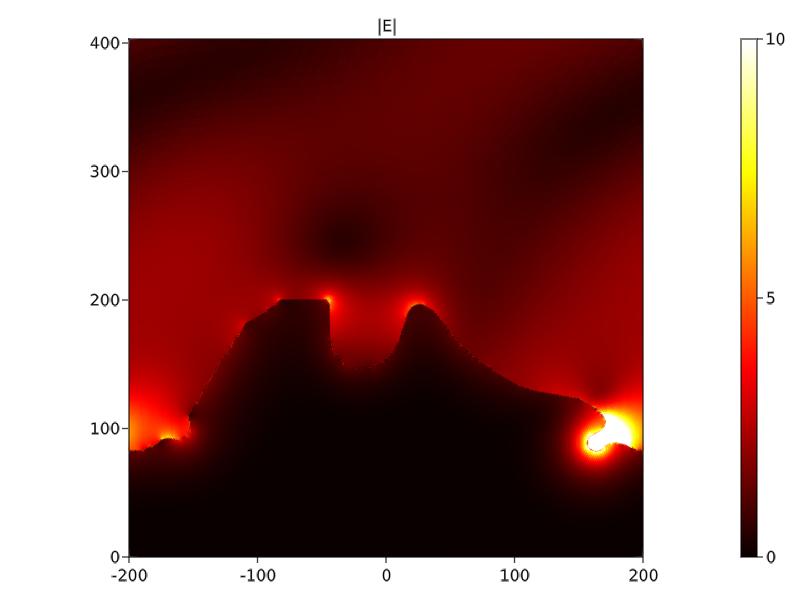

In [6]:
# p0=zeros(gridap.np)
# pf_vec = pf_p0(p0; control, gridap)
# pfh = FEFunction(gridap.FE_Pf, pf_vec)
# pth = (pf -> Threshold(pf; control)) ∘ pfh

# kb1 = VectorValue(sin(70/180*π) * ω1 * nf, 0)
# A1_mat = MatrixA(pth, kb1; phys=phys1, control, gridap)
# b1_vec = assemble_vector(v->(∫(v*(cos(70/180*π)))gridap.dΓ_s), gridap.FE_V)
# u1_vec = A1_mat \ b1_vec
# u1h = FEFunction(gridap.FE_U, u1_vec)
maxv = maximum(abs.(u1_vec))/1
maxe = 10.0#usat
if true
    e1=abs2(phys1.nf^2)
    e2=abs2(phys1.nm^2)
    uplot = u1h
    fig, ax, plt = plot(gridap.Ω, 2*(sqrt∘(abs((conj(∇(uplot)+1im*kb1*uplot) ⋅ (∇(uplot)+1im*kb1*uplot))/(e1 + (e2 - e1) * pth)))), colormap = :hot, colorrange=(0, maxe))
else
    e1=abs2(phys2.nf^2)
    e2=abs2(phys2.nm^2)
    uplot = v2h
    fig, ax, plt = plot(gridap.Ω, 2*(sqrt∘(abs((conj(∇(uplot)+1im*kb2*uplot) ⋅ (∇(uplot)+1im*kb2*uplot))/(e1 + (e2 - e1) * pth)))), colormap = :hot, colorrange=(0, maxe))
end
#fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
#fig, ax, plt = plot(gridap.Ω, abs2(u1h), colormap = :hot, colorrange=(0, maxv^2))
Colorbar(fig[1,2], plt)
#ax.title = "|H|"
ax.title = "|E|"
#ax.aspect = AxisAspect(L/(phys1.LHp[2]+phys1.LHn[2]))
#limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
ax.aspect = AxisAspect(L/(hd+hr*1))
limits!(ax, -L/2, L/2, 0, hd+hr*1)
save("Results/Field.png", fig)
fig

In [10]:
Neth = 50
damp = 4
eth_list = range(1,Neth,step=1)
g_sat = zeros(Neth)
psat = p0

kb1 = VectorValue(sin(0/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(0/180*π) * ω2 * nf, 0)

for ei = 1:Neth
    eth = eth_list[ei]
    usat = eth^2/4
    g_sat[ei] = g0_p(psat; kb1, kb2, phys1, phys2, control, gridap, usat, damp)/L/g_flat_surface
    open("532L400Sat.txt", "a") do io
        write(io, "$(g_sat[ei]) \n")
    end
end


4

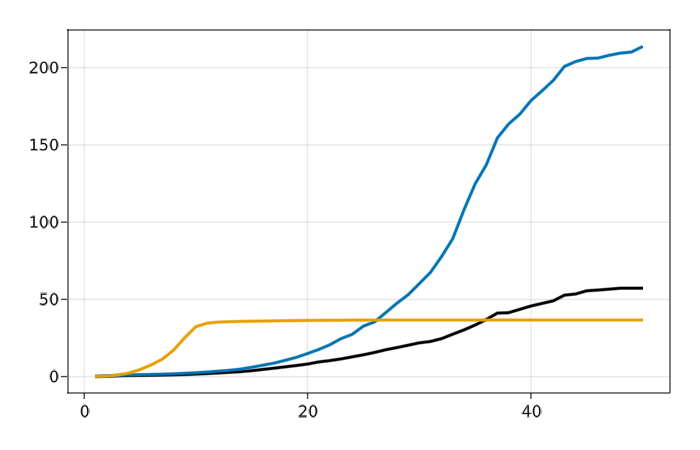

In [210]:
g1 = readdlm("Results/SatFun/$(λ1)CircleSat.txt")
g2 = readdlm("Results/SatFun/$(λ1)L400Sat.txt")
g3 = readdlm("Results/SatFun/$(λ1)L300Sat.txt")
g4 = readdlm("Results/SatFun/$(λ1)L100Sat.txt")
g5 = readdlm("Results/SatFun/$(λ1)L300Sat10.txt")
eth_list = range(1,50,step=1)

scene, layout = layoutscene(resolution=(1400/2,900/2))
ax = layout[1,1]=Axis(scene)
ms = 3

lin1 = lines!(ax,eth_list,g1[:],linewidth=ms,color=:black)
lin2 = lines!(ax,eth_list,g2[:],linewidth=ms)
#lin3 = lines!(ax,eth_list,g3[:],linewidth=ms)
#lin4 = lines!(ax,eth_list,g4[:],linewidth=ms)
lin5 = lines!(ax,eth_list,g5[:],linewidth=ms)
#ax.yscale = log10
# ax.xlabel="|Eth/E₀|"
# ax.ylabel="Power"
#ax.title="Eigenvalue distribution"

# Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
# axislegend(ax, [lin1, lin2, lin3, lin4, lin5],["Optimized Cylinder", "L=400 nm", "L=300 nm", "L=100 nm", "Optimized with |Eth/E₀|=10"], 
#     position = :lt, orientation = :vertical)
save("Results/SatFun/EF_Eth.png",scene)
scene

In [9]:
# gvalues = readdlm("gvalue.txt", Float64)
# gavlues = gvalues[:]
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_pkb1_optimize (generic function with 3 methods)

In [11]:
# ptest2 = rand(gridap.np+2)
# ptest2[end-1] = 0.5 * ω1
# ptest2[end] = 0.5 * ω2
# δp2 = rand(gridap.np+2)*1e-8
# grad2 = zeros(gridap.np+2)

ptest1 = rand(gridap.np+1)
ptest1[end] = 0.5 * ω2
δp1 = rand(gridap.np+1)*1e-8
grad1 = zeros(gridap.np+1)

usat = 5
damp = 1
theta1 = 30
# g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap)
# g1 = g0_p(p0+δp,[]; kb, phys1, phys2, control, gridap)
# g0 = g0_pkb(ptest2, grad2; phys1, phys2, control, gridap, usat, damp)
# g1 = g0_pkb(ptest2+δp2,[]; phys1, phys2, control, gridap, usat, damp)
g0 = g0_pkb1(ptest1, grad1; theta1, phys1, phys2, control, gridap, usat, damp)
g1 = g0_pkb1(ptest1+δp1,[]; theta1, phys1, phys2, control, gridap, usat, damp)
g1-g0, grad1'*δp1
#1.609129978462141e8

(-2.342075942074473e-7, -2.3395684738616117e-7)

In [36]:
ptest = rand(gridap.np)
δp = rand(gridap.np)*1e-8
grad = zeros(gridap.np)

kb1 = VectorValue(sin(70/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(-70/180*π) * ω2 * nf, 0)
usat = 5
damp = 1
# g0 = g0_p(p0, grad; kb, phys1, phys2, control, gridap)
# g1 = g0_p(p0+δp,[]; kb, phys1, phys2, control, gridap)
g0 = g0_p(ptest, grad; kb1, kb2, phys1, phys2, control, gridap, usat, damp)
g1 = g0_p(ptest+δp,[]; kb1, kb2, phys1, phys2, control, gridap, usat, damp)
g1, g0, g1-g0, grad'*δp
#1.609129978462141e8

(0.15114631491011513, 0.15114629820187364, 1.670824148480854e-8, 1.674430490576918e-8)

In [19]:
ptest2=zeros(gridap.np+2)
ptest2[1:end-2] = ptest[:]
ptest2[end-1] = 0.5 * ω1
ptest2[end] = 0.5 * ω2
g0_pkb(ptest2, []; phys1, phys2, control, gridap,usat,damp)

0.6183769111759724

In [ ]:
Nwave = 100
raman_shift = 17
gwave = zeros(Nwave)
λ1_list = zeros(Nwave)

p_max = readdlm("p_opt_value.txt", Float64)
p_cur = p_max[:]

for li = 1:Nwave
    λ1 = 532 +(li-25) * 5
    λ1_list[li] = λ1
    λ2 = λ1 + raman_shift
    nm1 = n_λ(λ1) + 1im * k_λ(λ1)
    nm2 = n_λ(λ2) + 1im * k_λ(λ2)
    ω1 = 2 * π / λ1
    phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
    ω2 = 2 * π / λ2
    phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)
    gwave[li] = g0_p(p_cur, []; kb=0, phys1, phys2, control, gridap)/control.Amp
end

scene, layout = layoutscene(resolution=(1400,900))
ax = layout[1,1]=Axis(scene)

lin1=lines!(ax,λ1_list, gwave[:])
# grad = zeros(gridap.np)
# g0_p(p0, grad; kb, phys1, phys2, control, gridap)
#ax.yscale = log10
ax.xlabel="λ"
ax.ylabel="Power"
#ax.title="Eigenvalue distribution"

# Legend(layout[1,1],[lin1, lin2],["Initial", "Optimized"])
# axislegend(ax, [lin1, lin2, lin3],["All","Far field","Difference"], position = :lt,
#     orientation = :vertical)
# save("Results/EigenValDistributionIO.png",scene)
scene

In [ ]:
Nperiod = 31
usat = Inf#(10)^2/4
damp = 4
gmax = zeros(Nperiod)
rmax = zeros(Nperiod)

kb1 = VectorValue(sin(0/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(-0/180*π) * ω2 * nf, 0)
for li = 1:Nperiod
    L = 100 + (li-1) * 10
    geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
    MeshGenerator(geo_param, meshfile)
    gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)

    for radius = 5:Int64(L/2)
        binitialfunc(v) = ∫(v * x->p_circle(x, radius))gridap.dΩ
        pc_vec = assemble_vector(binitialfunc, gridap.FE_P)
        p_init = p_extract(pc_vec; gridap)
        p_init[p_init .< 0.1] .= 0
        p_init[p_init .> 0.1] .= 1
        gtemp = g0_p(p_init; kb1, kb2, phys1, phys2, control, gridap, usat, damp)/L/g_flat_surface
        if gtemp > gmax[li]
            gmax[li] = gtemp
            rmax[li] = radius
        end
    end
    @show L, gmax[li], rmax[li]
end
rmax

In [ ]:
gmax = 0
dmax = 0
hmax = 0
for d = -19:1:1
    for h = 91:1:109
        bowtie_temp(v) = ∫(v * x->p_bowtie(x, d, h, L, hd))gridap.dΩ
        pc_vec = assemble_vector(bowtie_temp, gridap.FE_P)
        p_init = p_extract(pc_vec; gridap)
        p_init[p_init .< 0.1] .= 0
        p_init[p_init .> 0.1] .= 1
        @show gtemp = g0_p(p_init; kb1=0, kb2=0, phys1, phys2, control, gridap)/L/g_flat_surface
        if gtemp > gmax
            gmax = gtemp
            dmax = d
            hmax = h
        end
    end
end
gmax, dmax, hmax
# [100,1,180]

In [8]:
Nk = 9*2
gk12 = zeros(2*Nk-1, 2*Nk-1)
ptest = p0
for k1 = 1:(2*Nk-1)
    for k2 = 1:(2*Nk-1)
        kb1 = VectorValue(sin((k1-Nk)*π/2/Nk) * ω1 * nf, 0)
        kb2 = VectorValue(sin((k2-Nk)*π/2/Nk) * ω2 * nf, 0)
        gk12[k1, k2] = g0_p(ptest; kb1, kb2, phys1, phys2, control, gridap)/L/g_flat_surface
        open("L400AngleDependence.txt", "a") do io
        write(io, "$((k1/Nk-1)*90) $((k2/Nk-1)*90) $(gk12[k1,k2]) \n")
    end
    end
end

In [9]:
gkdata = readdlm("L300AngleDependence.txt", Float64)
Nk = 9*2
gk12 = zeros(2*Nk-1, 2*Nk-1)
angle1 = zeros(2*Nk-1)
angle2 = zeros(2*Nk-1)
for k1 = 1:(2*Nk-1)
    angle1[k1] = (k1/Nk-1)*90
    angle2[k1] = (k1/Nk-1)*90
    for k2 = 1:(2*Nk-1)
        gk12[k1,k2] = gkdata[(k1-1)*(2*Nk-1)+k2,3]
    end
end


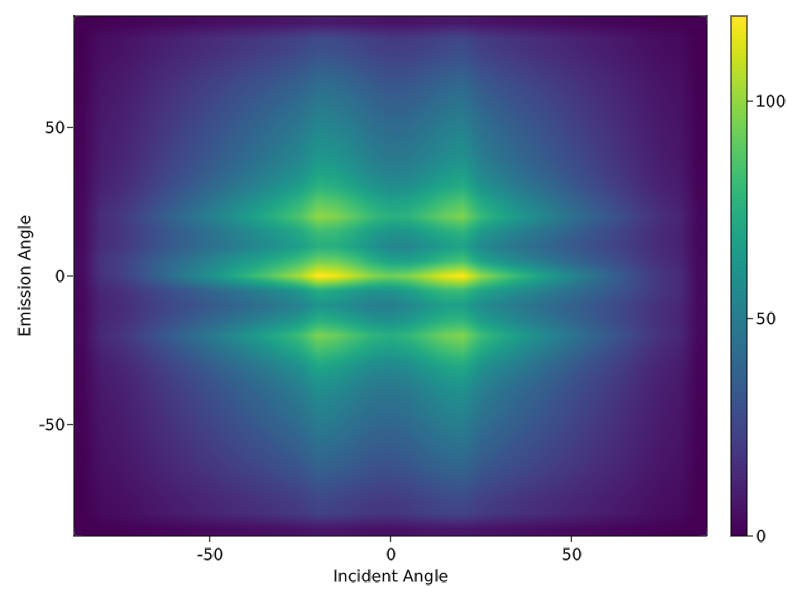

In [10]:

fig, ax1, hm1 = heatmap(angle1, angle2, gk12, interpolate=true, colorrange = (0, maximum(gk12)))

Colorbar(fig[1, 2], hm1)                     # These three
ax1.xlabel="Incident Angle"
ax1.ylabel="Emission Angle"
save("Results/L300_angle.png",fig)
fig

In [ ]:
sat_test(x, sat, damp) = 1 ./ (1 .+ exp.(damp*(x.-sat)))
xx = range(1,50,step=1)
lines(xx, sat_test(xx.^2, 20^2, 4))

In [11]:
findmax(gk12)

(178.79358907754636, CartesianIndex(18, 18))

In [12]:
angle1[18],angle2[18]

(0.0, 0.0)

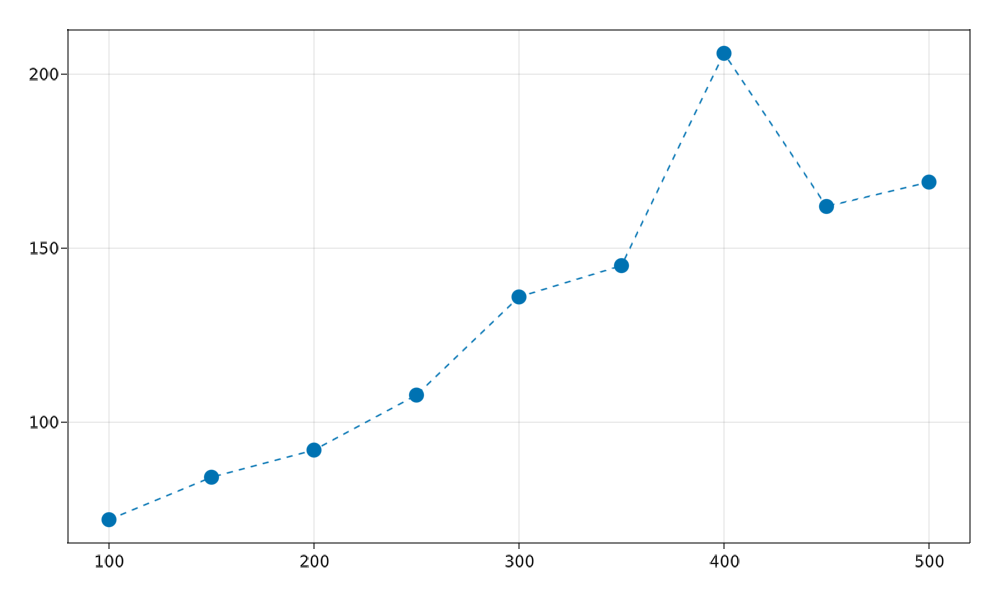

In [7]:
Periods = [100, 150, 200, 250, 300, 350, 400, 450, 500]
Powers = [72.0, 84.2, 92.0, 107.8, 136, 145, 206, 162, 169]
scene, layout = layoutscene(resolution=(1000,600))
ax = layout[1,1]=Axis(scene)

lin1=GLMakie.scatter!(ax,Periods, Powers,markersize=15)
lin1=GLMakie.lines!(ax,Periods, Powers,linestyle="--")
scene

In [11]:
L = 400   
hd = 200
meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
MeshGenerator(geo_param, meshfile)
gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)


# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
kb1 = VectorValue(sin(0/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(-0/180*π) * ω2 * nf, 0)

if ImportFromFile
    p_max = readdlm("Results/FigureData/L$(Int(L))_theta30_p_opt_value.txt", Float64)
    p0 = p_max[1:gridap.np]
    if length(p_max)==(gridap.np+2)
        kb1 = VectorValue(p_max[end-1],0)
        kb2 = VectorValue(p_max[end],0)
    elseif length(p_max)==(gridap.np+1)
        kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
        kb2 = VectorValue(p_max[end],0)
    end
else
    binitialfunc(v) = ∫(v * x->p_circle(x, 155))gridap.dΩ
    pc_vec = assemble_vector(binitialfunc, gridap.FE_P)
    p_init = p_extract(pc_vec; gridap)
    p_init[p_init .< 0.1] .= 0
    p_init[p_init .> 0.1] .= 1.0
    p0 = p_init
end
kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
kb2 = VectorValue(sin(0/180*π) * ω2 * nf, 0)
θ1 = asin(kb1[1]/phys1.nf/phys1.ω)
θ2 = asin(kb2[1]/phys2.nf/phys2.ω)
@show θ1/π*180, θ2/π*180
usat = Inf#(10)^2/4
damp = 4

pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb1; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v*sqrt(cos(θ1)))gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb2; phys=phys2, control, gridap)
o_vec = assemble_vector(v->(∫(v*sqrt(cos(θ2)))gridap.dΓ_t), gridap.FE_V)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

g0_p(p0; kb1, kb2, phys1, phys2, control, gridap, usat, damp)/L/g_flat_surface



Info    : No current model available: creating one
Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Reconstructing periodicity for curve connection 2 - 4
Info    : Reconstructing periodicity for curve connection 5 - 7
Info    : Reconstructing periodicity for curve connection 8 - 10
Info    : Reconstructing periodicity for curve connection 11 - 13
Info    : Reconstructing periodicity for curve connection 14 - 16
Info    : Reconstructing periodicity for curve connection 17 - 19
Info    : Reconstructing periodicity for curve connection 22 - 20
Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Meshing curve 3 (Line)
Info    : Meshing curve 4 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 9 (Line)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Me

216.30047710653835

In [12]:
using FileIO
using Images
import Images: Gray

scene1, ax1, plt1 = plot(gridap.Ω, pth+CellField(0,gridap.Ω), colormap = :binary)
ax1.aspect = AxisAspect(L/(hd+hr))
hidedecorations!(ax1)  # hides ticks, grid and lables
hidespines!(ax1)  # hide the frame
limits!(ax1, -L/2, L/2, 0, hd+hr)
shape_path = "Results/FigureData/shape.png"
save(shape_path, scene1)


maxe = 10.0
e1=abs2(phys1.nf^2)
e2=abs2(phys1.nm^2)
uplot = u1h
field_colormap = :hot
scene2, ax2, plt2 = plot(gridap.Ω, 2*(sqrt∘(abs((conj(∇(uplot)+1im*kb1*uplot) ⋅ (∇(uplot)+1im*kb1*uplot))/(e1 + (e2 - e1) * pth)))), colormap = field_colormap, colorrange=(0, maxe))
ax2.aspect = AxisAspect(L/(hd+hr))
hidedecorations!(ax2)  # hides ticks, grid and lables
hidespines!(ax2)  # hide the frame
limits!(ax2, -L/2, L/2, 0, hd+hr)

field_path = "Results/FigureData/field.png"
save(field_path, scene2)
shape_plot = load(shape_path)
field_plot = load(field_path)

shape_data = 1.0 .-Float64.(Gray.(shape_plot))
shape_data[shape_data.>0.5] .= 1.0
shape_data[shape_data.<=0.5] .= 0.0
combined_plot = field_plot[:,:]
for size1=1:size(field_plot)[1]
    for size2=1:size(field_plot)[2]
        if shape_data[size1,size2] > 0.5
            combined_plot[size1,size2] = RGB(0.5,0.5,0.5)
            shape_plot[size1,size2] = Gray(0.5)
        end
    end
end

save("Results/FigureData/L$(Int(L))_theta30_unit.png", combined_plot)

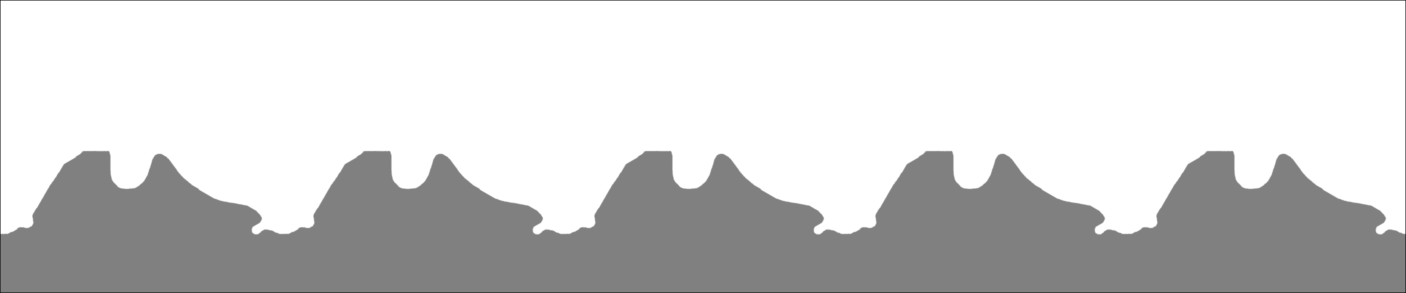

In [13]:
bottom_index = size(shape_data)[1]
left_index = 1
right_index = size(shape_data)[2]

for ishape = size(shape_data)[1]:-1:1
    if shape_data[ishape,Int(size(shape_data)[2]/2)] > 0.5
        bottom_index = ishape
        break
    end
end

for ishape = 2:size(shape_data)[2]
    s1 = shape_data[bottom_index,ishape-1]
    s2 = shape_data[bottom_index,ishape]
    if  s1 < 0.5 && s2 > 0.5
        left_index = ishape + 1
    end
    if  s1 > 0.5 && s2 < 0.5
        right_index = ishape - 2
    end
end
unit_shape_plot = shape_plot[1:bottom_index,left_index:right_index]
unit_field_plot = field_plot[1:bottom_index,left_index:right_index]

shape_period = hcat(unit_shape_plot,unit_shape_plot,unit_shape_plot,unit_shape_plot,unit_shape_plot)
field_period = hcat(unit_field_plot,unit_field_plot,unit_field_plot,unit_field_plot,unit_field_plot)
save("Results/FigureData/L$(Int(L))_theta30_shape.png", shape_period)
save("Results/FigureData/L$(Int(L))_theta30_field.png", field_period)
shape_period

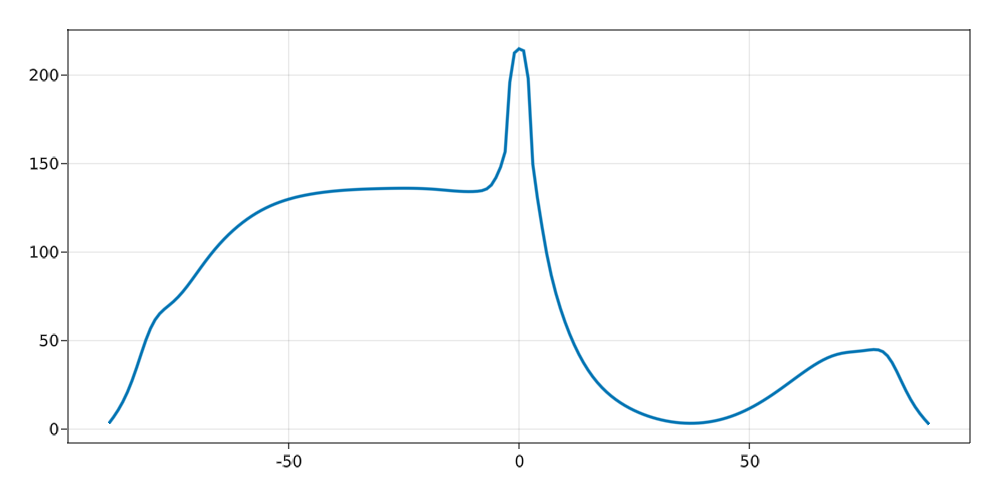

In [14]:
g_angle_data = readdlm("Results/FigureData/L$(Int(L))_theta30_AngleDependence.txt", Float64)
g_angle = g_angle_data[:,3]
angles = g_angle_data[:,2]

scene, layout = layoutscene(resolution=(1000,500))
ax = layout[1,1]=GLMakie.Axis(scene)

lin1=GLMakie.lines!(ax,angles, g_angle, linewidth=3)
scene

(real(v2_vec' * B_mat * v2_vec) / L) / g_flat_surface = 136.7761656124982


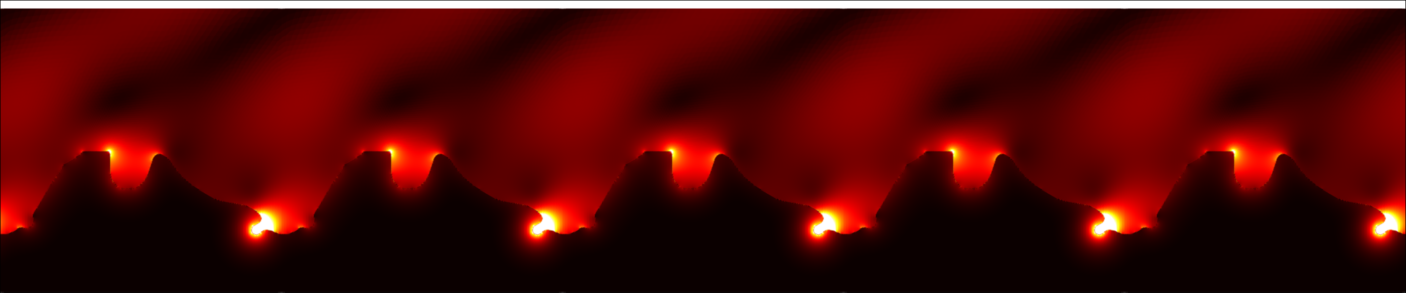

In [17]:
kb2 = VectorValue(sin(-30/180*π) * ω2 * nf, 0)
c2 = sqrt(1-(kb2[1]/phys2.nf/phys2.ω)^2)
B_mat = MatrixB(pth, u1h; control, gridap, usat, damp, e1=abs2(phys1.nf^2), e2=abs2(phys1.nm^2), e3=abs2(phys2.nm^2))


A2_mat = MatrixA(pth, kb2; phys=phys2, control, gridap)
o_vec = assemble_vector(v->(∫(v*sqrt(c2))gridap.dΓ_t), gridap.FE_V)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

@show real(v2_vec' * B_mat * v2_vec)/L/g_flat_surface

maxe = 10.0
e1=abs2(phys2.nf^2)
e2=abs2(phys2.nm^2)
uplot = v2h
field_colormap = :hot
scene2, ax2, plt2 = plot(gridap.Ω, 2*(sqrt∘(abs((conj(∇(uplot)+1im*kb2*uplot) ⋅ (∇(uplot)+1im*kb2*uplot))/(e1 + (e2 - e1) * pth)))), colormap = field_colormap, colorrange=(0, maxe))
ax2.aspect = AxisAspect(L/(hd+hr))
hidedecorations!(ax2)  # hides ticks, grid and lables
hidespines!(ax2)  # hide the frame
limits!(ax2, -L/2, L/2, 0, hd+hr)

field_path = "Results/FigureData/field.png"
save(field_path, scene2)
shape_plot = load(shape_path)
field_plot = load(field_path)

bottom_index = size(shape_data)[1]
left_index = 1
right_index = size(shape_data)[2]

for ishape = size(shape_data)[1]:-1:1
    if shape_data[ishape,Int(size(shape_data)[2]/2)] > 0.5
        bottom_index = ishape
        break
    end
end

for ishape = 2:size(shape_data)[2]
    s1 = shape_data[bottom_index,ishape-1]
    s2 = shape_data[bottom_index,ishape]
    if  s1 < 0.5 && s2 > 0.5
        left_index = ishape + 1
    end
    if  s1 > 0.5 && s2 < 0.5
        right_index = ishape - 2
    end
end
unit_field_plot = field_plot[1:bottom_index,left_index:right_index]

field_period = hcat(unit_field_plot,unit_field_plot,unit_field_plot,unit_field_plot,unit_field_plot)
save("Results/FigureData/L$(Int(L))_theta30_field.png", field_period)
field_period

In [105]:
r = (2, 2)  # Filter radius

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)



kb1 = VectorValue(sin(30/180*π) * ω1 * nf, 0)
c1 = sqrt(1-(kb1[1]/phys1.nf/phys1.ω)^2)
usat = Inf#(10)^2/4
damp = 4
p_max = readdlm("Results/FigureData/L$(Int(L))_theta30b_p_opt_value.txt", Float64)
p0 = p_max[1:gridap.np]

pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb1; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v*c1)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

B_mat = MatrixB(pth, u1h; control, gridap, usat, damp, e1=abs2(phys1.nf^2), e2=abs2(phys1.nm^2), e3=abs2(phys2.nm^2))
u1_vec'*u1_vec

4.9449721005954385e8 + 0.0im

In [109]:
kb2 = VectorValue(sin(-1/180*π) * ω2 * nf, 0)
c2 = sqrt(1-(kb2[1]/phys2.nf/phys2.ω)^2)

A2_mat = MatrixA(pth, kb2; phys=phys2, control, gridap)
o_vec = assemble_vector(v->(∫(v*c2)gridap.dΓ_t), gridap.FE_V)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)


g_temp = v2_vec' * B_mat * v2_vec
real(g_temp)/L/g_flat_surface/c2/c1, real(v2_vec'*v2_vec)

(183.6465953514878, 9.430445505976729e8)

In [100]:
kbtest1 = VectorValue(sin(0/180*π) * ω2 * nf, 0)
Atest1 = MatrixA(pth, kbtest1; phys=phys2, control, gridap)
utest1 = Atest1' \ o_vec

kbtest2 = VectorValue(sin(0.1/180*π) * ω2 * nf, 0)
Atest2 = MatrixA(pth, kbtest2; phys=phys2, control, gridap)
utest2 = Atest2' \ o_vec
sum(abs.(utest2.-utest1)./abs.(utest1))/length(utest1)

0.010579448690463926

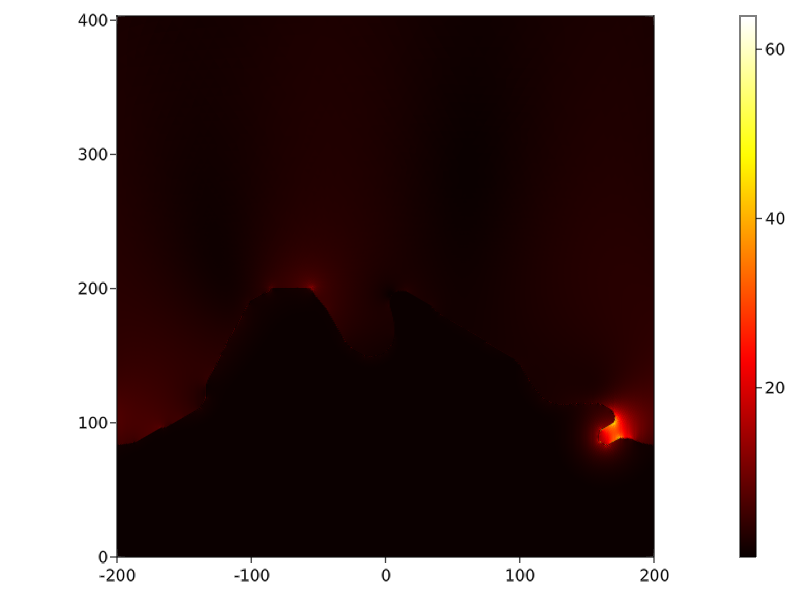

In [88]:
maxe = 10.0
e1=abs2(phys1.nf^2)
e2=abs2(phys1.nm^2)
uplot = v2h
field_colormap = :hot
scene2, ax2, plt2 = plot(gridap.Ω, 2*(sqrt∘(abs((conj(∇(uplot)+1im*kb2*uplot) ⋅ (∇(uplot)+1im*kb2*uplot))/(e1 + (e2 - e1) * pth)))), colormap = field_colormap)
ax2.aspect = AxisAspect(L/(hd+hr))
Colorbar(scene2[1,2], plt2)
# hidedecorations!(ax2)  # hides ticks, grid and lables
# hidespines!(ax2)  # hide the frame
limits!(ax2, -L/2, L/2, 0, hd+hr)
scene2